In [1]:
# Paths: 

# Ubuntu:
project_path = '/home/mk/Desktop/T1/P5/'

# Paths:
model_path = project_path + 'model.pkl'
scaler_path = project_path + 'scaler.pkl'

data_nonvehicles_path = project_path + 'data/non-vehicles/*/*.png'
data_vehicles_path = project_path + 'data/vehicles/*/*.png'

image_var_1 = project_path + 'data/P4/test_images/test1.jpg'
image_var_2 = project_path + 'data/P4/test_images/test2.jpg'
image_var_3 = project_path + 'data/P4/test_images/test3.jpg'
image_var_4 = project_path + 'data/P4/test_images/test4.jpg'
image_var_5 = project_path + 'data/P4/test_images/test5.jpg'
image_var_6 = project_path + 'data/P4/test_images/test6.jpg'

test_video_var = project_path + 'data/test_video.mp4'
test_video_res_var = 'test_video_res_v.0.0.1.0.3+.mp4.mp4'
video_var = project_path + 'data/P4/project_video.mp4'
video_res_var = 'project_video_res_v.0.0.1.0.3+.mp4'

In [2]:
# Imports:
from IPython.display import HTML
from moviepy.editor import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from collections import deque
from random import random
import scipy.misc
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from skimage.feature import hog

/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [3]:
class Params:

    def __init__(self,
                 # Lesson 26:
                 # performs under different binning scenarios
                 spatialX=32,
                 spatialY=32,
                 hist_bins=32,
                 bins_range=(0, 256),
                 
                 # Lesson 27: 
                 color_space='YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
                 orient=12, #8 #9
                 pix_per_cell=8,
                 cell_per_block=2,
                 hog_channel='0',#0, # 0 # Can be 0, 1, 2, or 'ALL'
                 
                 # Additional parameters:
                 classifier_img_size=(64,64),
                 window_inclusion_threshold=2.5,#2.05,#1.5,#2.1, #1,2,4
                 xy_windows=[ (48,48), (64,64), (96,96), (128,128), (192,192)], 
                 # (64,64), (96,96), (128,128), (192,192), (256,256)
                 xy_overlaps=[(0.5,0.5)],#(0.25,0.25), (0.5,0.5)
                 track_frames=30,#10,#1, #5
                 heatmap_threshold=2.5,#1.0(tv),#0.9 (testvid) #0.7,#0.5,#0.3,# 0.1,#0.8,#2.1#0.9,#0.99,# 0.8,# 0.5, #1, # 0.5, #2 #8 ------------
                 spatial_feat=True, 
                 hist_feat=True,
                 hog_feat=True,
                 C=0.0001,
                 box_color=(0, 0, 255), 
                 box_thickness=6 ):
        """
        Parameter class init.
        """
        self.spatialX=spatialX
        self.spatialY=spatialY
        self.spatial_size=(spatialX,spatialY)
        
        self.hist_bins=hist_bins
        self.bins_range=bins_range
        self.color_space=color_space
        self.orient=orient
        self.pix_per_cell=pix_per_cell
        self.cell_per_block=cell_per_block
        self.hog_channel=hog_channel
        self.classifier_img_size=classifier_img_size
        self.window_inclusion_threshold=window_inclusion_threshold
        self.xy_windows=xy_windows
        self.xy_overlaps=xy_overlaps
        self.track_frames=track_frames
        self.heatmap_threshold=heatmap_threshold
        self.spatial_feat=spatial_feat
        self.hist_feat=hist_feat
        self.hog_feat=hog_feat
        self.C=C
        self.box_color=box_color
        self.box_thickness=box_thickness
        

In [4]:
# Lesson 5. Manual vehicle detection
# Lesson 32. Search and classify
def draw_boxes(img, bboxes, color, thick): # params in lesson: color=(0, 0, 255), thick=6
    # Make a copy of the image
    draw_img = np.copy(img)
    ### Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)  
    # Return the image copy with boxes drawn
    return draw_img

# Lesson 12. Histograms of color
# Lesson 32. Search and classify
# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Lesson 15. Spatial binning of color
# Lesson 32. Search and classify
# Compute color histogram features  
# Receives the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space, size): 
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

# Lesson 19. scikit-image HOG()
# Lesson 27. HOG Classify
# Lesson 32. Search and classify
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis, feature_vec): 
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Lesson 30. Sliding window implementation
# Lesson 32. Search and classify
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, xy_window, xy_overlap, x_start_stop=[None, None], y_start_stop=[None, None]): 
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [5]:
# Lesson 34. Multiple detections & false positives
class CarHeatmapLabels:

    def __init__(self,
                 track_frame_number,
                 heatmap_threshold):
        self.heatmap_threshold=heatmap_threshold
        self.track_frame_number=track_frame_number
        self.frames = deque(maxlen=track_frame_number)

    def track_cars(self, windows, img_height, img_width, image_process_vis=False): 
        self.frames.append(windows)
        heatmap = np.zeros((img_height, img_width), dtype=np.uint8)
        tracking_windows = []
        for frame in self.frames:
            tracking_windows.extend(frame)
        CarHeatmapLabels.add_heat(heatmap, tracking_windows)
        heatmap_thres = CarHeatmapLabels.apply_threshold(heatmap, self.heatmap_threshold)
        labels = label(heatmap_thres)
        if image_process_vis:
            fig = plt.figure()
            plt.subplot(131)
            plt.imshow(heatmap, cmap=plt.get_cmap('jet'))
            plt.title('Image with heatmap', fontsize=6)
            plt.subplot(132)
            plt.imshow(heatmap_thres, cmap=plt.get_cmap('jet'))
            plt.title('Image with heatmap and inclusion threshold', fontsize=6)
            plt.subplot(133)
            plt.imshow(labels[0], cmap=plt.get_cmap('gray'))
            plt.title('Image with cars', fontsize=6)
            plt.show()
        return labels

    # Lesson 34. Multiple detections & false positives
    def add_heat(heatmap, bbox_list): 
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap
 
    def apply_threshold(heatmap, threshold):
        # Zero out pixels below ehe threshold
        heatmap_thres = np.copy(heatmap)
        heatmap_thres[heatmap_thres <= threshold] = 0
        # Return thresholded map
        return heatmap_thres
    
    # Lesson 34. Multiple detections & false positives
    def draw_labeled_bboxes(img, labels):########## class
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,255,255), 6)
        # Return the image
        return img

In [6]:
def hog_visualization( img, feature_image, color_space='' ):
    
    hog_vis_images = []
    
    for channel in range(feature_image.shape[2]):
        hog_features_single_channel, hog_image = get_hog_features(feature_image[:,:,channel], 
                                                                          params.orient, 
                                                                          params.pix_per_cell, 
                                                                          params.cell_per_block, 
                                                                          vis=True, 
                                                                          feature_vec=True)
        hog_vis_images.append(hog_image)
    
    fig = plt.figure()
    plt.subplot(141)
    plt.imshow(img, cmap='gray')
    plt.title(color_space+'Image',fontsize=6)
    plt.subplot(142)
    plt.imshow(hog_vis_images[0], cmap='gray')
    plt.title(color_space+'CH-0 Hog', fontsize=6)
    plt.subplot(143)
    plt.imshow(hog_vis_images[1], cmap='gray')
    plt.title(color_space+'CH-1 Hog', fontsize=6)
    plt.subplot(144)
    plt.imshow(hog_vis_images[2], cmap='gray')
    plt.title(color_space+'CH-2 Hog', fontsize=6)
    plt.show()
    
# Extended version of single_img_features() from Lesson 32. Search and classify 
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, params, hog_vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if (params.color_space != 'RGB'):
        if params.color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif params.color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif params.color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif params.color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif params.color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if params.spatial_feat == True:
        spatial_features = bin_spatial(feature_image, color_space=params.color_space, size=params.spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if params.hist_feat == True:
        hist_features = color_hist(feature_image, nbins=params.hist_bins, bins_range=params.bins_range)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if params.hog_feat == True:
        
        hog_features_all = []
        
        if hog_vis == True:
            hog_visualization( img, np.copy(img), 'RGB ' )
            hog_visualization( img, cv2.cvtColor(img, cv2.COLOR_RGB2HSV), 'HSV ' )
            hog_visualization( img, cv2.cvtColor(img, cv2.COLOR_RGB2LUV), 'LUV ' )
            hog_visualization( img, cv2.cvtColor(img, cv2.COLOR_RGB2HLS), 'HLS ' )
            hog_visualization( img, cv2.cvtColor(img, cv2.COLOR_RGB2YUV), 'YUV ' )
            hog_visualization( img, cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb), 'YCrCb ' )
            
        elif params.hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features_single_channel = get_hog_features(feature_image[:,:,channel], 
                                                                   params.orient, 
                                                                   params.pix_per_cell, 
                                                                   params.cell_per_block, 
                                                                   hog_vis, 
                                                                   feature_vec=True)
                hog_features_all.extend( hog_features_single_channel )
                ### hog_features = np.ravel(hog_features) # in Lesson 32. extract_features(...)
        else:
            hog_features_all = get_hog_features(feature_image[:,:,params.hog_channel], 
                                                         params.orient, params.pix_per_cell, params.cell_per_block, 
                                                         hog_vis, feature_vec=True)
            ### hog_features = np.ravel(hog_features) # in Lesson 32. extract_features(...)
        #8) Append features to list 
        img_features.append( hog_features_all )
       
    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Extended version of extract_features() from Lesson 32. Search and classify 
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, params, hog_vis):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        # Get image features for each image:
        image_features = single_img_features( img=image, params=params, hog_vis=hog_vis )
        
        # Append features of the specific image to the list of features of all images:
        features.append(image_features)
    # Return list of feature vectors
    return features

In [7]:
# Extended version of code in: 
# Lesson 26. Color Classify 
# Lesson 27. HOG Classify
# Lesson 32. Search and classify
def classify( data_vehicles_path, 
             data_nonvehicles_path, 
             model_path, 
             scaler_path,
             hog_vis,
             params ):
    
    # Load cars and notcars:
    images_cars = glob.glob( data_vehicles_path )
    cars = []
    for image in images_cars:
        cars.append( image )
    
    images_notcars = glob.glob( data_nonvehicles_path )
    notcars = []
    for image in images_notcars:
        notcars.append( image )
    
    # Reduce the sample size because HOG features are slow to compute
    # The quiz evaluator times out after 13s of CPU time
    #sample_size = 500
    #cars = cars[0:sample_size]
    #notcars = notcars[0:sample_size]
    
    if hog_vis==True:
        hog_vis_cars_ind = np.random.randint(0, len(cars))
        hog_vis_car_image = mpimg.imread(cars[hog_vis_cars_ind])
        hog_vis_car_features = single_img_features( img=hog_vis_car_image, params=params, hog_vis=hog_vis )
        hog_vis_notcars_ind = np.random.randint(0, len(notcars))
        hog_vis_notcar_image = mpimg.imread(notcars[hog_vis_notcars_ind])
        hog_vis_notcar_features = single_img_features( img=hog_vis_notcar_image, params=params, hog_vis=hog_vis )
        
    car_features = extract_features( imgs=cars, params=params, hog_vis=False)
    notcar_features = extract_features( imgs=notcars, params=params, hog_vis=False)
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    
    # Fit a per-column scaler and save scaler:
    X_scaler = StandardScaler().fit(X)
    joblib.dump(X_scaler, scaler_path)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split( scaled_X, y, test_size=0.2, random_state=rand_state )

    print('Using:',params.orient,'orientations; ',params.pix_per_cell, 'pixels per cell; ',
          params.cell_per_block,'cells per block; (', params.spatialX,',',params.spatialY, ') spatial bins;',
         params.hist_bins, 'histogram_bins.')
    print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC 
    svc = LinearSVC(C=params.C)
    
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))

    # Save classifier:
    joblib.dump(svc, model_path)
    
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [8]:
# Partially based on search_windows() from Lesson 32. Search and classify
# Define a function you will pass an image to be searched 
def search_windows_with_cars_in_image( img, 
                                      windows,
                                      params,
                                      classifier, 
                                      scaler,
                                      hog_vis ):
    features = []
    for window in windows:
            (startx,starty), (endx, endy) = window
            image = cv2.resize( img[starty:endy, startx:endx, :], params.classifier_img_size ) 
            image_features = single_img_features( img=image, params=params, hog_vis=hog_vis )
            features.append( image_features )
    test_features = scaler.fit_transform( features ) 
    
    # Use SVC decision_function() as suggested in forum
    car_value_list = classifier.decision_function( test_features )
    windows_with_cars = []
    for car_value, window in zip( car_value_list, windows ):
        if ( car_value > params.window_inclusion_threshold ):  
            windows_with_cars.append( window )
    
    return windows_with_cars

# Partially based on search_windows() from Lesson 32. Search and classify
# Define a function you will pass an image to be searched 
def search_image( img, 
                 params,
                 classifier,
                 scaler,
                 hog_vis ):
            
    windows_with_cars_in_image_allWindowSizes = []  

    for i, (xy_window, xy_overlap) in enumerate(zip( params.xy_windows, params.xy_overlaps )):
        
        img_height = img.shape[0]
        img_width  = img.shape[1]
        view_height = int(img_height/2)
        y_start_stop=[view_height, img_height]
        xy_nums = (int(view_height/xy_window[1])*2,
                   int(img_width/xy_window[0])*2)
        
        windows = slide_window(img, 
                               xy_window=xy_window, 
                               xy_overlap=xy_overlap, 
                               y_start_stop=y_start_stop)
        
        windows_with_cars_in_image = search_windows_with_cars_in_image( img, 
                                                                       windows,
                                                                       classifier=classifier, 
                                                                       scaler=scaler, 
                                                                       params=params,
                                                                       hog_vis=hog_vis)
            
    windows_with_cars_in_image_allWindowSizes.extend(windows_with_cars_in_image)
 
    return windows_with_cars_in_image_allWindowSizes

In [9]:
# Extended version of code in Lesson 32. Search and classify
def image_process_func( img,
                       params,
                       scaler,
                       classifier,
                       carHeatmapLabels,
                       image_process_vis=False,
                       hog_vis=False,
                      is_video_frame=False):
    
    img = np.copy(img)
    all_car_window_list = search_image(img, 
                                       params,
                                       classifier=classifier, 
                                       scaler=scaler,
                                       hog_vis=hog_vis )
    
    # Lesson 30:
    if image_process_vis:
        show_img = draw_boxes(img, all_car_window_list, color=params.box_color, thick=params.box_thickness) 
        plt.imshow(show_img)
        plt.title('Image with boxes')
        plt.show()
    
    track_cars = carHeatmapLabels.track_cars(all_car_window_list, 
                                        img_height=img.shape[0], 
                                        img_width=img.shape[1], 
                                        image_process_vis=image_process_vis)
    window_img= CarHeatmapLabels.draw_labeled_bboxes(img, track_cars)
    if image_process_vis:
        plt.imshow(window_img)
        plt.title('Image with boxes around cars')
        plt.show()
    
    if is_video_frame == True:
        return window_img # returns images as np-array

In [10]:
# Video processing: 
def video_process_func( frame ):
    
    return image_process_func(
        frame, 
        #cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
        params=params,
        carHeatmapLabels=carHeatmapLabels,
        scaler=scaler,    
        classifier=classifier,
        is_video_frame=True
)

In [11]:
# Run everything:

In [12]:
params = Params()

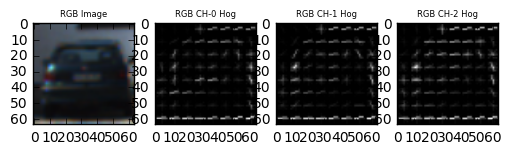

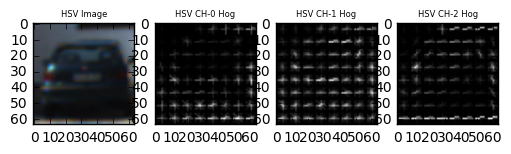

/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:88: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


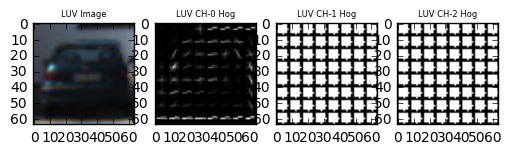

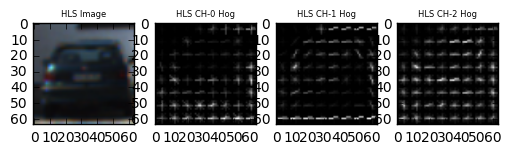

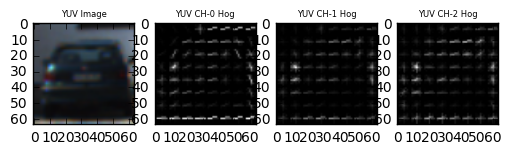

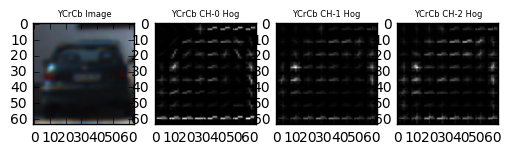

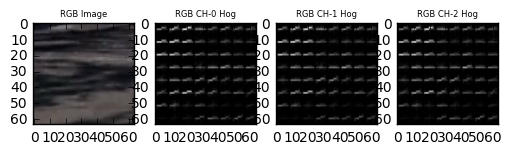

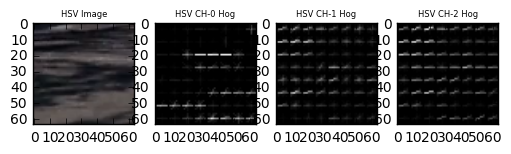

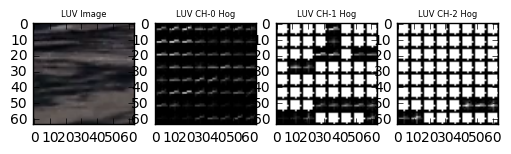

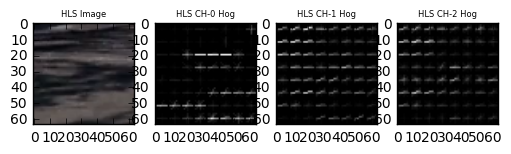

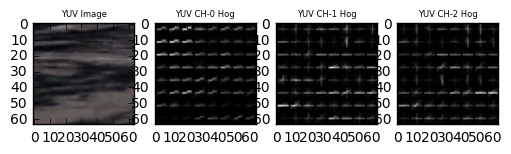

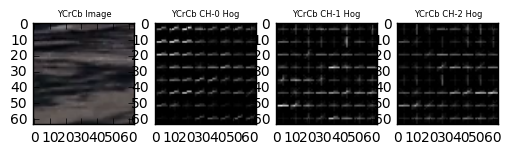

/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Using: 12 orientations;  8 pixels per cell;  2 cells per block; ( 32 , 32 ) spatial bins; 32 histogram_bins.
Feature vector length: 5520
4.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9829
Train Accuracy of SVC =  0.989
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  0.  0.  0.  0.]
0.00144 Seconds to predict 10 labels with SVC


In [13]:
classify( data_vehicles_path=data_vehicles_path, 
         data_nonvehicles_path=data_nonvehicles_path,
         model_path=model_path, 
         scaler_path=scaler_path,
         params=params,
         hog_vis=True )

In [14]:
scaler = joblib.load( scaler_path )

In [15]:
classifier = joblib.load( model_path )

In [16]:
carHeatmapLabels = CarHeatmapLabels( track_frame_number=params.track_frames, 
                  heatmap_threshold=params.heatmap_threshold )

/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


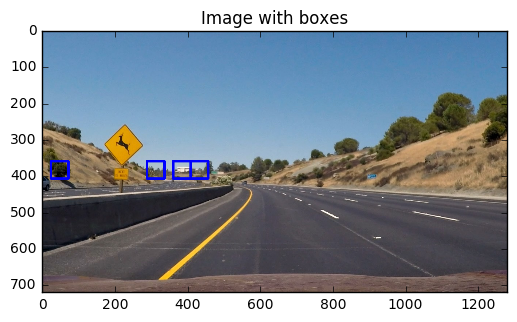

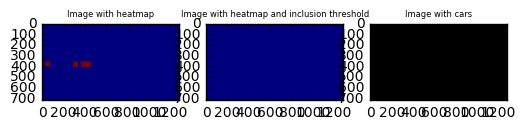

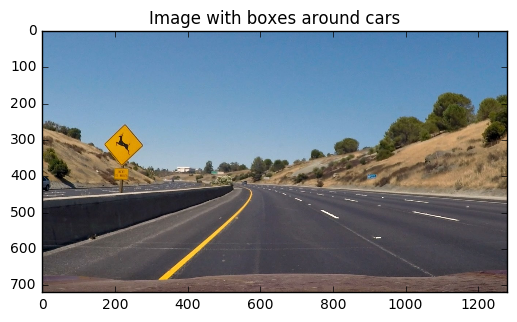

In [17]:
# Test image: 
image_process_func(
    mpimg.imread(image_var_2),
    classifier=classifier,
    scaler=scaler,
    carHeatmapLabels=carHeatmapLabels,
    params=params,
    image_process_vis=True)

/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


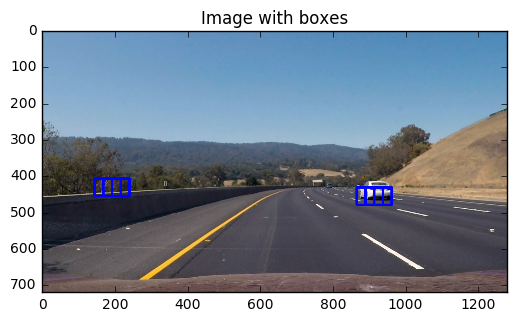

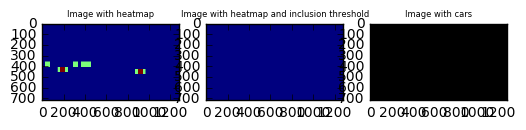

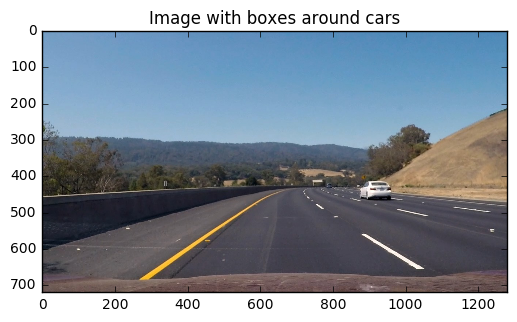

In [18]:
# Test image: 
image_process_func(
    mpimg.imread(image_var_3),
    classifier=classifier,
    scaler=scaler,
    carHeatmapLabels=carHeatmapLabels,
    params=params,
    image_process_vis=True)

/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


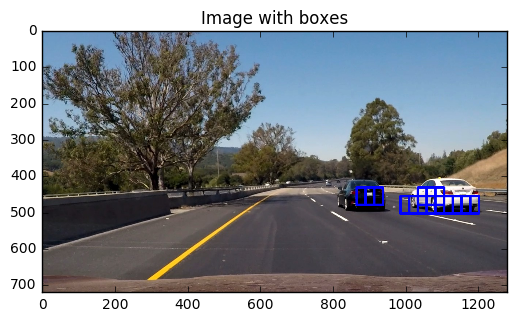

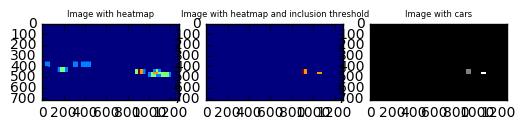

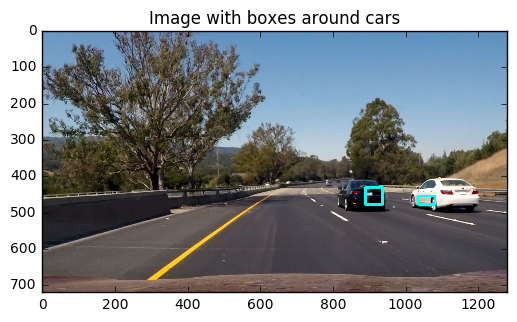

In [19]:
# Test image: 
image_process_func(
    mpimg.imread(image_var_6),
    classifier=classifier,
    scaler=scaler,
    carHeatmapLabels=carHeatmapLabels,
    params=params,
    image_process_vis=True)

In [20]:
# Test video: 
test_video = VideoFileClip( test_video_var ).fl_image( video_process_func ) # load test_video 

/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [21]:
%time test_video.write_videofile( test_video_res_var, audio=False) # store video with car boxes (takes some time because executes video processing frame by frame)


MoviePy: building video file test_video_res_v.0.0.1.0.3+.mp4.mp4
----------------------------------------

Writing video into test_video_res_v.0.0.1.0.3+.mp4.mp4


100%|██████████| 37/37 [01:13<00:00,  1.89s/it]


Done writing video in test_video_res_v.0.0.1.0.3+.mp4.mp4 !
Your video is ready !
CPU times: user 1min 24s, sys: 356 ms, total: 1min 24s
Wall time: 1min 15s


In [22]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format( test_video_res_var ))

In [23]:
# Full project video:
video = VideoFileClip( video_var ).fl_image( video_process_func ) # load video 

/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/moviepy/audio/io/readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))
/home/mk/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [24]:
video.write_videofile( video_res_var, audio=False) # store video with car boxes (takes some time because executes video processing frame by frame)


MoviePy: building video file project_video_res_v.0.0.1.0.3+.mp4
----------------------------------------

Writing video into project_video_res_v.0.0.1.0.3+.mp4


100%|██████████| 1210/1210 [38:58<00:00,  1.94s/it]


Done writing video in project_video_res_v.0.0.1.0.3+.mp4 !
Your video is ready !


In [25]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format( video_res_var ))

In [26]:
print('Done.')

Done.
